In [ ]:
'''
This is script is for: 
(A) looking at dimensionality between flashes and 
(B) bootstrapping dimensionality to make sure that effects are real and not a wierd function 
of e.g. sample size
--> in this case, boostraping is a leave-n-out, where the dimensionality is computed repeately 
    with a random subset of the overall data.
    
Created by Yoni Browning, August 2018
'''

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib as mpl
import scipy as sp
import numpy as np
import pandas as pd
# sometimes order maters on these
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import oBehave.plotting_stuff as obps
import oBehave.helperfunctions as obhf
import oBehave.neural_analysis as obna
import oBehave.behavior_analysis as obba
import sklearn.decomposition as decomp
from sklearn.model_selection import train_test_split
import sklearn.decomposition as decomp
from sklearn.preprocessing import StandardScaler

from visual_behavior.ophys.dataset.visual_behavior_ophys_dataset import VisualBehaviorOphysDataset
from visual_behavior.ophys.response_analysis.utilities import get_trace_around_timepoint,get_nearest_frame
from visual_behavior.ophys.response_analysis.response_analysis import ResponseAnalysis

experiment_id = 639438856# experiment B
#experiment_id = 639253368

/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Load the manifest
manifest = obhf.load_manifest()
obba.includeNovelSession(manifest);

In [3]:
# Loat a single data set
dataset= VisualBehaviorOphysDataset(experiment_id=experiment_id, cache_dir=obhf.drive_path)
analysis = ResponseAnalysis(dataset)

loading trial response dataframe
loading flash response dataframe


In [4]:
# Define some functions we will need...In the long run there should be sent to ob as callable functions
def killnancells(dataset,analysis):
    bad_cell_indices = []
    bad_cell_ids = []
    for cell_index in range(dataset.dff_traces[1].shape[0]):
        if np.isnan(dataset.dff_traces[1][cell_index][0]): #check whether first datapoint is nan
           bad_cell_indices.append(cell_index)
           bad_cell_ids.append(dataset.get_cell_specimen_id_for_cell_index(cell_index))
    fdf = analysis.flash_response_df.copy()
    fdf = fdf[fdf.cell.isin(bad_cell_indices)==False]
    return fdf

In [5]:
# We want to bootstrap dim analysis. Get the data ready
num_trials = len(dataset.stimulus_table)
fr = killnancells(dataset,analysis)
use_cells = np.unique(fr.cell)
response_array = np.empty((num_trials,len(use_cells)))
for i in range(num_trials):
    response_array[i,:] = fr[fr.flash_number==i].mean_response.values
    


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

77

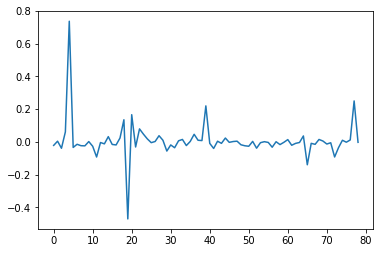

In [7]:
#sanity check. It would be sad to lie to everyone, so just make sure array sizes make sense :<)
pca = decomp.PCA()
pca.fit(response_array)
# visualize a PC (or two!)
plt.plot(pca.components_[8,:])
use_cells[np.argsort(abs(pca.components_[5,:]))[-1]]
#print(pca.components_[0])

In [8]:
# functions for computing and bootstrapping dimension
def getDimension(response_array, useStandardScaler =False):
    response_array = np.array(response_array) 
    if useStandardScaler:
        SS = StandardScaler()
        response_array = SS.fit_transform(response_array)
    PCA = decomp.PCA()
    PCA.fit(response_array-response_array.mean())
    D_star = 1/sum((PCA.explained_variance_ratio_)**2.)
    return D_star

# Bootstrap by leaving out random subsets of cells, building subpops of sizes
# 1 to N-1. Note that this should be 2 to N-1, since once cell has dim 1, but 
# I forgot to change it before running.
def boostrapDimension(response_array,Nboots = None,useStandardScaler = False):
    # Number of cells
    num_cells = response_array.shape[1]
    # Default number of bootstraps is the number of cells. 
    # this really only makes sense in the special case of N-1 cells.
    if Nboots is None:
        Nboots = num_cells
    # Do the bootstraping, calculating the dimension
    PCA = decomp.PCA()
    if useStandardScaler:
        SS = StandardScaler()
    store_boots = np.zeros((num_cells-1,Nboots))
    for ii in range(1,num_cells):
        for jj in range(Nboots):
            try:
                tmp = response_array[:,np.random.choice(num_cells,ii)]
                if useStandardScaler:
                    tmp = SS.fit_transform(tmp)
                PCA.fit(tmp-tmp.mean())
                D = 1/sum((PCA.explained_variance_ratio_)**2.)
                store_boots[ii-1,jj] = D
            except np.linalg.LinAlgError:
                store_boots[ii-1,jj] = np.isnan
    return store_boots

In [9]:
# test out the new block assignment.
fr = killnancells(dataset,analysis)
fb = obba.includeAddRepeats_dataset(dataset.stimulus_table,dataset.all_trials)

In [ ]:
# Do the boostrapping for each session. Save result as pickle
# while we are boostrapping, also look at first vs. not first flashes, in addition to 
# data containing all flashes. Bootstap all of it, because this for loop takes a while 
# and we wont want to run it again if something interesting comes out.
manifest.head()
tmp_manifest = manifest[(manifest.targeted_structure=='VISp')&manifest.cre_line.str.contains('Slc')&(manifest.first_session)]

keylist = ['experiment_id','targeted_structure','session_type','donor_id','full_dim','dim_ss','dim_first','dim_notfirst','bootresults','bootresults_ss','bootresults_first','bootresults_notfirst']
dimdata = {k:[] for k in keylist}
Nboots = 1000
colorlist = plt.rcParams['axes.prop_cycle'].by_key()['color']
for idx,row in tmp_manifest.iterrows():
    print('Started ' +str(counter)+': ' + str(row.experiment_id))
    # load the dataset
    dataset= VisualBehaviorOphysDataset(experiment_id=row.experiment_id, cache_dir=obhf.drive_path)
    analysis = ResponseAnalysis(dataset)
    fb = obba.includeAddRepeats_dataset(dataset.stimulus_table,dataset.all_trials)
    # Compute the response array
    num_trials = len(dataset.stimulus_table)
    fr = killnancells(dataset,analysis)
    use_cells = np.unique(fr.cell)
    # Full response array
    response_array = np.empty((num_trials,len(use_cells)))
    for i in range(num_trials):
        response_array[i,:] = fr[fr.flash_number==i].mean_response.values
    # Get the full dimensionality
    D_star = getDimension(response_array)
    store_boots = boostrapDimension(response_array,Nboots)
    D_ss = getDimension(response_array,useStandardScaler=True)
    store_boots_ss = boostrapDimension(response_array,Nboots,useStandardScaler=True)
    dimdata['experiment_id'].append(row.experiment_id)
    
    # SubsetArrayResponse
    # First responces
    X = fr.merge(fb,left_on = ('flash_number','start_time','image_name'),
                 right_on = ('flash_number','start_time','image_name'),how= 'left') 
    X_tmp = X[X.repeats==1]
    use_cells = np.unique(X_tmp.cell)
    first_trials = np.unique(X_tmp.flash_number[X_tmp.repeats==1])
    response_array_first = np.empty((len(first_trials),len(use_cells)))
    first_flashes = X_tmp[X_tmp.repeats==1].flash_number.values
    for i,f in enumerate(first_trials):
        response_array_first[i,:] = X_tmp[X_tmp.flash_number==f].mean_response.values
    D_first = getDimension(response_array_first)
    store_boots_first = boostrapDimension(response_array_first,Nboots)
    
    # Not first responces
    X_tmp = X[X.repeats!=1]
    use_cells = np.unique(X_tmp.cell)
    notfirst_trials = np.unique(X_tmp.flash_number[X_tmp.repeats!=1])
    response_array_notfirst = np.empty((len(notfirst_trials),len(use_cells)))
    notfirst_flashes = X_tmp[X_tmp.repeats!=1].flash_number.values
    for i,f in enumerate(notfirst_trials):
        response_array_notfirst[i,:] = X_tmp[X_tmp.flash_number==f].mean_response.values
    D_notfirst = getDimension(response_array_notfirst)
    store_boots_notfirst = boostrapDimension(response_array_notfirst,Nboots)
    
    # save output
    dimdata['session_type'].append(row.session_type)
    dimdata['targeted_structure'].append(row.targeted_structure)
    dimdata['donor_id'].append(row.donor_id)
    dimdata['full_dim'].append(D_star.copy())
    dimdata['dim_ss'].append(D_ss.copy())
    dimdata['dim_first'].append(D_first.copy())
    dimdata['dim_notfirst'].append(D_notfirst.copy())
    dimdata['bootresults'].append(store_boots.copy())
    dimdata['bootresults_ss'].append(store_boots_ss.copy())
    dimdata['bootresults_first'].append(store_boots_first.copy())
    dimdata['bootresults_notfirst'].append(store_boots_notfirst.copy())
    # print
    print('Dim = ' + str(D_star))
DimData = pd.DataFrame(dimdata)
DimData.to_pickle('./DimReductionBootstrap_allwsubsets_VISp_Slc.pkl')

Started 0: 652844352
loading trial response dataframe
loading flash response dataframe
Dim = 5.360926174140501
Started 0: 653053906
loading trial response dataframe
loading flash response dataframe
Dim = 11.130728412557778
Started 0: 653123781
loading trial response dataframe
loading flash response dataframe
Dim = 11.427267824359681
Started 0: 639253368
loading trial response dataframe
loading flash response dataframe
Dim = 2.5137646902742894
Started 0: 639438856
loading trial response dataframe
loading flash response dataframe
Dim = 7.3256750425118575
Started 0: 639769395
loading trial response dataframe
loading flash response dataframe
Dim = 14.605911824189485
Started 0: 639932228
loading trial response dataframe
loading flash response dataframe


In [15]:
#DimData = pd.DataFrame(dimdata)
#DimData.to_pickle('./DimReductionBootstrap_allwsubsets_VISp_Slc.pkl')

Text(0.5,1,'Slc, VISp')

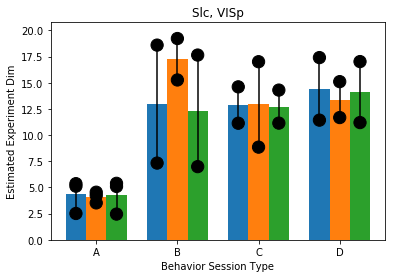

In [20]:
# Plot Ave, 1st flash, not first flash dim for each session type.
DimFrame = DimData.merge(manifest,left_on = ['experiment_id','donor_id','session_type','targeted_structure'],right_on = ['experiment_id','donor_id','session_type','targeted_structure'],how = 'left')
behs = ['behavior_session_A','behavior_session_B','behavior_session_C','behavior_session_D']
scat = []
colorlist = plt.rcParams['axes.prop_cycle'].by_key()['color']
for ii,s in enumerate(behs):
    this_data = DimFrame[(DimFrame.targeted_structure=='VISp')
                         &(DimFrame['cre_line']=='Slc17a7-IRES2-Cre')#'Vip-IRES-Cre')#'Vip-IRES-Cre')#
                         &(DimFrame['session_type']==s)]['full_dim'].values
    this_data1 = DimFrame[(DimFrame.targeted_structure=='VISp')
                     &(DimFrame['cre_line']=='Slc17a7-IRES2-Cre')#'Vip-IRES-Cre')#'Vip-IRES-Cre')#
                     &(DimFrame['session_type']==s)]['dim_first'].values
    this_data2 = DimFrame[(DimFrame.targeted_structure=='VISp')
                 &(DimFrame['cre_line']=='Slc17a7-IRES2-Cre')#'Vip-IRES-Cre')#'Vip-IRES-Cre')#
                 &(DimFrame['session_type']==s)]['dim_notfirst'].values
    scat.append(this_data)
    #print(this_data)
    plt.scatter(ii*np.ones((len(this_data),1)),this_data,color = 'K',marker = 'o',zorder = 3,s = [150]*len(this_data))#np.oness((len(this_data),)))
    plt.bar(ii,np.mean(this_data),yerr = sp.std(this_data),color = colorlist[0],width = .25)
    
    plt.scatter(ii*np.ones((len(this_data1),1))+.25,this_data1,color = 'K',marker = 'o',zorder = 3,s = [150]*len(this_data1))#np.oness((len(this_data),)))
    plt.bar(ii+.25,np.mean(this_data1),yerr = sp.std(this_data1),color = colorlist[1],width = .25)
    
    plt.scatter(ii*np.ones((len(this_data2),1))+.5,this_data2,color = 'K',marker = 'o',zorder = 3,s = [150]*len(this_data2))#np.oness((len(this_data),)))
    plt.bar(ii+.5,np.mean(this_data2),yerr = sp.std(this_data2),color = colorlist[2],width = .25)

plt.xticks(np.array([0,1,2,3])+.25,['A','B','C','D'])
plt.ylabel('Estimated Experiment Dim')
plt.xlabel('Behavior Session Type')
plt.title('Slc, VISp')

Text(0,0.5,'Estimated Dimension')

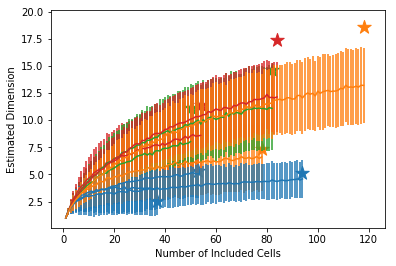

In [32]:
# Plot boostrap results
# NOTE: this code has a std comand in right now, Eric thinks the more
#      proper way to see these curves is with standard error of mean. I like 
#      STD for visualization of pop variance, though
colorlist = plt.rcParams['axes.prop_cycle'].by_key()['color']
for ths,row in DimData.iterrows():
    if 'A' in row.session_type:
        cc =colorlist[0]
        ll = 'A'
    elif 'B' in row.session_type:
        cc =colorlist[1]
        ll = 'B'
    elif 'C' in row.session_type:
        cc =colorlist[2]
        ll = 'C'
    else:
        cc =colorlist[3]
        ll = 'D'

    plt.errorbar(range(1,DimData.bootresults[ths].shape[0]+1),DimData.bootresults[ths].mean(axis = 1),yerr = DimData.bootresults[ths].std(axis = 1),color = cc)
    plt.scatter(DimData.bootresults[ths].shape[0],DimData.full_dim[ths],marker= '*',s = 200,color = cc,label = ll)
#plt.legend()
plt.xlabel('Number of Included Cells')
plt.ylabel('Estimated Dimension')


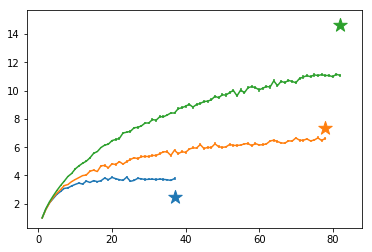

In [21]:
# plot for one mouse, since seeing all the data is overwhelming
ths = 3
plt.errorbar(range(1,DimData.bootresults[ths].shape[0]+1),DimData.bootresults[ths].mean(axis = 1),yerr = sp.stats.sem(DimData.bootresults[ths],axis = 1))
plt.scatter(DimData.bootresults[ths].shape[0],DimData.full_dim[ths],marker= '*',s = 200)
ths = 4
plt.errorbar(range(1,DimData.bootresults[ths].shape[0]+1),DimData.bootresults[ths].mean(axis = 1),yerr = sp.stats.sem(DimData.bootresults[ths],axis = 1))
plt.scatter(DimData.bootresults[ths].shape[0],DimData.full_dim[ths],marker= '*',s = 200)
ths = 5
plt.errorbar(range(1,DimData.bootresults[ths].shape[0]+1),DimData.bootresults[ths].mean(axis = 1),yerr = sp.stats.sem(DimData.bootresults[ths],axis = 1))
plt.scatter(DimData.bootresults[ths].shape[0],DimData.full_dim[ths],marker= '*',s = 200)

#plt.errorbar(range(1,DimData.bootresults[3].shape[0]+1),DimData.bootresults[3].mean(axis = 1),yerr = DimData.bootresults[3].std(axis = 1))


In [ ]:
# X_tmp = X[X.repeats==1]
# use_cells = np.unique(X_tmp.cell)
# first_trials = np.unique(X_tmp.flash_number[X_tmp.repeats==1])
# response_array_first = np.empty((len(first_trials),len(use_cells)))
# first_flashes = X_tmp[X_tmp.repeats==1].flash_number.values
# for i,f in enumerate(first_trials):
#     response_array_first[i,:] = X_tmp[X_tmp.flash_number==f].mean_response.values
# pca = decomp.PCA()
# pca.fit(response_array_first)
# pca.components_.shape
# 1/np.sum(pca.explained_variance_ratio_**2)

In [ ]:
# X_tmp = X[X.repeats!=1]
# use_cells = np.unique(X_tmp.cell)
# notfirst_trials = np.unique(X_tmp.flash_number[X_tmp.repeats!=1])
# response_array_notfirst = np.empty((len(notfirst_trials),len(use_cells)))
# notfirst_flashes = X_tmp[X_tmp.repeats!=1].flash_number.values
# for i,f in enumerate(notfirst_trials):
#     response_array_notfirst[i,:] = X_tmp[X_tmp.flash_number==f].mean_response.values
# pca = decomp.PCA()
# pca.fit(response_array_notfirst)
# pca.components_.shape
# 1/np.sum(pca.explained_variance_ratio_**2)

In [ ]:
# # Not lets grab only cases where it is the first flash
# num_trials = len(dataset.stimulus_table)
# fr = killnancells(dataset,analysis)
# use_cells = np.unique(fr.cell)
# response_array = np.empty((num_trials,len(use_cells)))
# for i in range(num_trials):
#     response_array[i,:] = fr[fr.flash_number==i].mean_response.values
# #sanity check. It would be sad to lie to everyone :<)
# pca = decomp.PCA()
# pca.fit(response_array)
# pca.components_.shape

In [ ]:
#     # get rid of data in fb so that it doesn't use all our memory
#     keeplist = [fr.columns[ll] for ll in range(len(fr.columns))]#.append('repeats').append('block')
#     keeplist.append('repeats')
#     keeplist.append('block')
#     killthese = [(cc not in keeplist) for ll,cc in enumerate(fb.columns)]
#     fb = fb.drop(columns = fb.columns[killthese])